# Notebook for evaluating trained CNNs
- Load trained LCU
- Select folder with eval data (idea is that test = patched and predict = not patched). So incorporate both ways.
- Create DL with same label mappings as original. 
- Predict those, figure out way to show images of memory-mapped images (ie predict set)
- Or just stick with test set up for now? 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
sys.path.append('scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch, torchvision, torchsummary
import pytorch_lightning as pl
# import segmentation_models_pytorch as smp

path_dict = loadpaths.loadpaths()

## Use trained CNN to make predictions of unseen data:

In [3]:
# LCU = lcm.load_model(filename='scripts/LCU_2022-11-17-1659.data')
LCU = lcm.load_model(filename='scripts/LCU_2022-11-18-0537.data')
LCU.eval()

# ## From https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html#save-a-checkpoint

# ## LightningModule from checkpoint
# ## To load a LightningModule along with its weights and hyperparameters use the following method:

# model = LCU.load_from_checkpoint("/path/to/checkpoint.ckpt")


LandCoverUNet class

In [12]:
dir_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/gradbach_6tiles/12.5cm Aerial Photo/117383-1_RGB_1_Shape/images/'
dir_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/gradbach_6tiles/12.5cm Aerial Photo/117383-1_RGB_1_Shape/masks/'
path_mapping_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl'

n_classes = 7
# n_classes = LCU.n_classes
assert n_classes == 7
test_ds = lcm.DataSetPatches(im_dir=dir_im_patches, mask_dir=dir_mask_patches, 
                            preprocessing_func=LCU.preprocessing_func, path_mapping_dict=path_mapping_dict,
                            subsample_patches=False, frac_subsample=1)
assert test_ds.n_classes == n_classes
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=4, num_workers=16)

tmp_class_name_list = ['NO CLASS', 'Wood and Forest Land', 'Moor and Heath Land', 'Agro-Pastoral Land',
                       'Water and Wetland', 'Rock and Coastal Land', 'Developed Land']

Patches ordered randomly
Loaded label_mapping_dict__main_categories__2022-11-17-1512.pkl to map labels


(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>


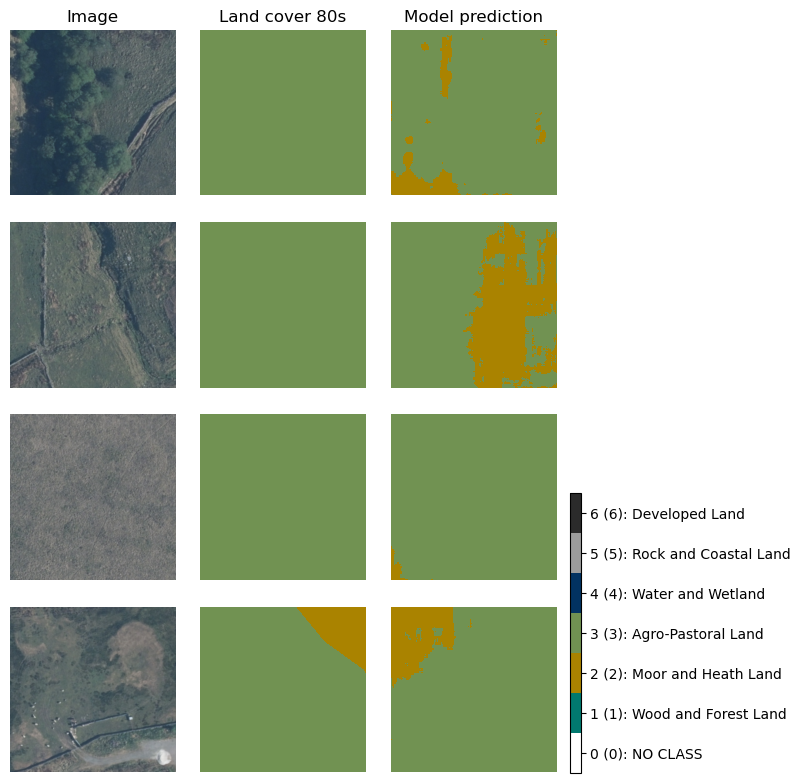

In [16]:
kk += 4
tmp_batch = lcm.get_batch_from_ds(ds=test_ds, batch_size=4, start_ind=kk)
_ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU, 
                                         batch=tmp_batch,
                                        #  test_dl=test_dl, 
                                         preprocessing_fun=test_ds.preprocessing_func,
                                         lc_class_name_list=tmp_class_name_list, unique_labels_array=np.arange(7))

In [27]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)  # run on GPU; and set max_epochs.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
## Predict the labels of unseen data => use test data for now so we can compare performance to (LC 80s) 'ground truth'
pred_test = trainer.predict(LCU, test_dl)  # returns list of tensors (one tensor for each batch)
pred_test = lca.concat_list_of_batches(pred_test)  # concatenate batches
## LCU outputs a softmax (ie 1 probability for each class) => get argmax for visual comparison
pred_test = lca.change_tensor_to_max_class_prediction(pred=pred_test)

In [8]:
# all_ims = lca.concat_list_of_batches([test_ds[x][0][None, :, :, :] for x in range(1350)])
# all_masks = lca.concat_list_of_batches([torch.Tensor(test_ds[x][1][None, :, :]) for x in range(1350)])

In [9]:
# dict_mapping = pickle.load(open(path_mapping_dict, 'rb'))           
# mapping_label_to_new_dict = dict_mapping['dict_label_mapping']
# unique_labels_arr = np.array(list(dict_mapping['dict_label_mapping'].keys()))
# class_name_list = list(dict_mapping['dict_new_names'].values())
# n_classes = len(class_name_list)

## Compare two shp files
E.g.,
- predicted vs true 
- past vs present 

Will focus on evaluation tiles. 


In [153]:
dict_df_lc_raw = {}

dict_df_lc_raw['80s'] = lca.load_pols(pol_path=path_dict['lc_80s_path'])
dict_df_lc_raw['22'] = lca.load_pols(pol_path=path_dict['evaluation_50tiles_polygons'])

df_tiles_eval = lca.load_pols(pol_path=path_dict['evaluation_50tiles'])
assert len(df_tiles_eval) == 50
assert np.isclose(df_tiles_eval['geometry'].area, 1e6, atol=1e2).all()

In [154]:
dict_df_lc_raw['80s']

,AREA,PERIMETER,LC_N_80,LC_D_80,MI_PRINX,geometry
0,2.288935e+05,1931.281171,19,Improved Pasture,1,"POLYGON ((407724.666 411168.713, 407854.641 41..."
1,8.103939e+05,6180.868624,12,Upland Heath/Grass Mosaic,2,"POLYGON ((407267.642 410992.244, 407326.372 41..."
2,3.024182e+06,30493.715242,7,Upland Grass Moor,3,"POLYGON ((405616.816 409724.857, 405615.571 40..."
3,3.141201e+06,17829.297205,8,Blanket Peat Grass Moor,4,"POLYGON ((406402.661 410926.453, 406419.695 41..."
4,5.524007e+03,360.239964,20,Rough Pasture,5,"POLYGON ((405569.382 410874.398, 405584.644 41..."
...,...,...,...,...,...,...
8477,2.946860e+03,210.674150,19,Improved Pasture,8478,"POLYGON ((416356.527 348866.777, 416357.591 34..."
8478,1.588031e+03,186.955561,1,Broadleaved High Forest,8479,"POLYGON ((412660.720 348649.559, 412658.280 34..."
8479,6.253066e+03,340.410463,36,Isolated Farmsteads (>0.25 ha),8480,"POLYGON ((412871.439 348609.371, 412858.033 34..."
8480,1.770921e+05,2285.262979,2,Coniferous High Forest,8481,"POLYGON ((411786.076 405491.149, 411803.349 40..."


In [183]:
dict_dict_intersect_eval = {}
dict_df_eval_tiles_lc = {}
for key, curr_df in dict_df_lc_raw.items():
    if 'Class_Code' not in curr_df.columns:
        print(f'Adding class codes to {key}')
        dict_df_lc_raw[key] = lca.add_main_category_column(df_lc=curr_df)  # add main category label
    dict_df_lc_raw[key] = lca.test_validity_geometry_column(df=dict_df_lc_raw[key])
    dict_dict_intersect_eval[key] = lca.get_pols_for_tiles(df_pols=dict_df_lc_raw[key] , df_tiles=df_tiles_eval, 
                                                           col_name='PLAN_NO', extract_main_categories_only=True)
    dict_df_eval_tiles_lc[key] = pd.concat(list(dict_dict_intersect_eval[key].values())).reset_index(drop=True)
    dict_df_eval_tiles_lc[key] = dict_df_eval_tiles_lc[key].assign(area=dict_df_eval_tiles_lc[key]['geometry'].area)
    dict_df_eval_tiles_lc[key] = lca.add_main_category_name_column(df_lc=dict_df_eval_tiles_lc[key])


100%|██████████| 50/50 [00:00<00:00, 228.17it/s]


In [180]:
for key in ['80s', '22']:
    print('\n', key)
    print(dict_df_lc_raw[key]['geometry'].area.sum() / 1e6)
    print(dict_df_eval_tiles_lc[key]['geometry'].area.sum() / 1e6)
    print(np.sum([dict_dict_intersect_eval[key][x]['geometry'].area.sum() for x in dict_dict_intersect_eval[key].keys()]) / 1e6)


 80s
1438.3501369982669
49.95786873755686
49.957868737556865

 22
50.00061109514263
50.000602540111494
50.000602540111494


In [194]:
key = '80s'
area_tiles_arr = [dict_dict_intersect_eval[key][x]['geometry'].area.sum() for x in dict_dict_intersect_eval[key].keys()]
names_tiles_arr = [x for x in dict_dict_intersect_eval[key]]
inds_sorted_area = np.argsort(area_tiles_arr)
names_tiles_arr[inds_sorted_area[0]]


'SK0682'

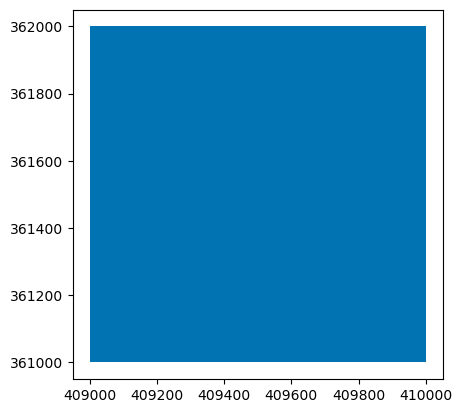

In [191]:
df_tiles_eval[df_tiles_eval['PLAN_NO'] == 'SK0961'].plot()

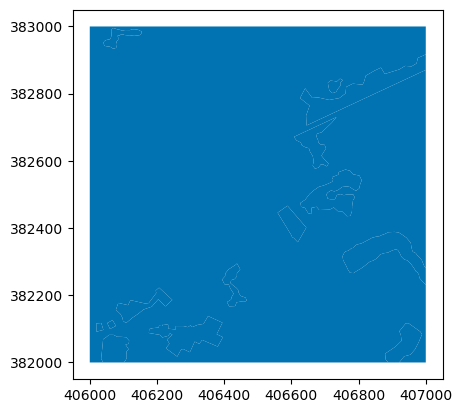

In [196]:
dict_dict_intersect_eval['22']['SK0682'].plot()

['Wood and Forest Land', 'Moor and Heath Land', 'Agro-Pastoral Land', 'Water and Wetland', 'Rock and Coastal Land', 'Developed Land', 'Unclassified Land']


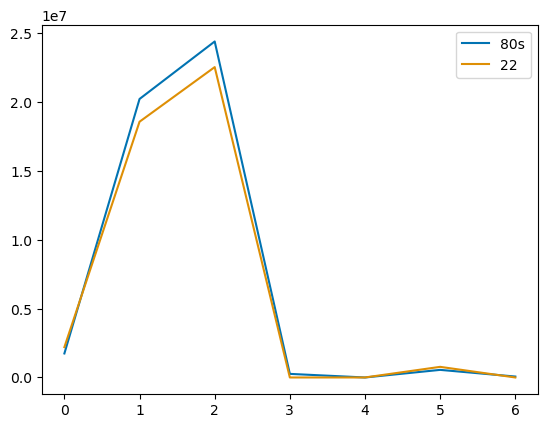

In [220]:
tmp = lcv.plot_difference_total_lc_from_dfs(dict_dfs=dict_df_eval_tiles_lc)

In [224]:
tmp['22'].sum()

44023420.5966369

# TODO
- Take intersection of pols and PD outline. Then leave No CLass/unclassified as a label 
- Total net gain/loss per LC (horizontal bar plot; sum pol areas)
- Gain & loss per pair of LCs. (Confusion matrix; loop through old pols and find intersection with new & add to count of new area)
